# Árvores II - Tarefa 2

### 1. Carregar as bases

Vamos carregar as bases lidas na tarefa passada. Se você salvou essas bases em arquivo texto, basta fazer a leitura com o comando ```pd.read_csv``` das seguintes bases:

- X_train
- Y_train
- X_test
- Y_test

Não se esqueça de considerar a leitura dos índices dos arquivos no ```read_csv()```!

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
features = pd.read_csv(
    "./Dataset/features.txt",
    sep="\s+",
    header=None,
    names=["index", "feature_name"]
)

# Treino
subject_train = pd.read_csv("./Dataset/train/subject_train.txt", header=None, names=["subject"])
X_train = pd.read_csv("./Dataset/train/X_train.txt", sep="\s+", header=None)
y_train = pd.read_csv("./Dataset/train/y_train.txt", header=None, names=["activity"])

# Teste
subject_test = pd.read_csv("./Dataset/test/subject_test.txt", header=None, names=["subject"])
X_test = pd.read_csv("./Dataset/test/X_test.txt", sep="\s+", header=None)
y_test = pd.read_csv("./Dataset/test/y_test.txt", header=None, names=["activity"])

# Nomeando colunas
X_train.columns = features["feature_name"]
X_test.columns = features["feature_name"]

# Adicionando sujeito e atividade (com alinhamento correto)
X_train["subject"] = subject_train["subject"].values
X_train["activity"] = y_train["activity"].values

X_test["subject"] = subject_test["subject"].values
X_test["activity"] = y_test["activity"].values

# Selecionar colunas de interesse
colunas_selecionadas = [
    "tBodyAcc-mean()-X",
    "tBodyAcc-mean()-Y",
    "tBodyAcc-mean()-Z",
    "subject",
    "activity"
]

X_train_reduzido = X_train[colunas_selecionadas]
X_test_reduzido = X_test[colunas_selecionadas]

print("Treino reduzido:", X_train_reduzido.shape)
print("Teste reduzido:", X_test_reduzido.shape)
print("\nExemplo de treino reduzido:")
print(X_train_reduzido.head(3))

Treino reduzido: (7352, 5)
Teste reduzido: (2947, 5)

Exemplo de treino reduzido:
feature_name  tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
0                      0.288585          -0.020294          -0.132905   
1                      0.278419          -0.016411          -0.123520   
2                      0.279653          -0.019467          -0.113462   

feature_name  subject  activity  
0                   1         5  
1                   1         5  
2                   1         5  


### 2. Divisão da base em Treino, Validação e Teste

A base já se encontra dividida em Treino e Validação. O que vamos fazer então é extrair uma base de Validação da base de Treino.

Extraia 25% da base de treino como base de validação.

In [3]:
# Verificando se ainda há NaN
print("\nTem NaN em activity?", X_train_reduzido["activity"].isnull().sum())

# Separar features e target
X = X_train_reduzido.drop(columns=["activity"])
y = X_train_reduzido["activity"]

# Divisão treino/validação
X_train_split, X_valid, y_train_split, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=1729
)

print("\nTreino:", X_train_split.shape)
print("Validação:", X_valid.shape)


Tem NaN em activity? 0

Treino: (5514, 4)
Validação: (1838, 4)


### 3. Melhores 3 variáveis

Rode uma árvore com profundidade máxima igual a 4 para prever a atividade humana com todas as variáveis.
Observe a importância das variáveis e considere as 3 variáveis com maior importância para os próximos passos.
Dica: utilize o atributo ```clf.feature_importances_``` da árvore treinada.


Top 3 variáveis mais importantes:
feature_name
tBodyAcc-mean()-X    0.663471
tBodyAcc-mean()-Y    0.234620
tBodyAcc-mean()-Z    0.101909
dtype: float64


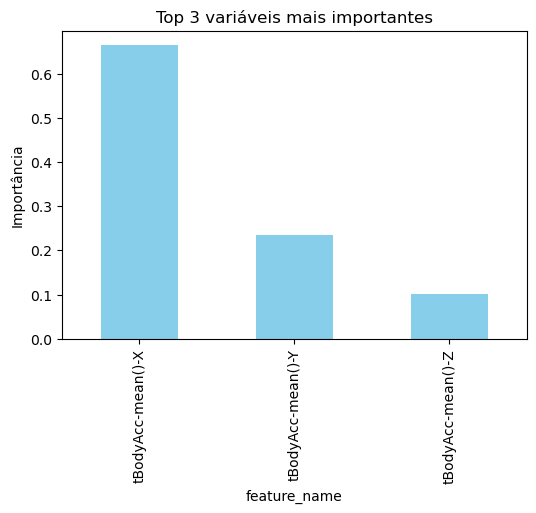

In [4]:
# Treinar árvore de decisão
clf = DecisionTreeClassifier(max_depth=4, random_state=1729)
clf.fit(X_train_split, y_train_split)

# Importância das variáveis
importancias = pd.Series(clf.feature_importances_, index=X.columns)
importancias_ordenadas = importancias.sort_values(ascending=False)

# Top 3
top3 = importancias_ordenadas.head(3)
print("\nTop 3 variáveis mais importantes:")
print(top3)

plt.figure(figsize=(6, 4))
top3.plot(kind='bar', color='skyblue')
plt.title("Top 3 variáveis mais importantes")
plt.ylabel("Importância")
plt.show()

### 4. Construa uma árvore com as 3 melhores variáveis

Utilizando as três variáveis encontradas acima, construa uma árvore de decisão. Encontre o melhor ```ccp_alpha``` utilizando a base de validação, conforme a estrutura que vimos em aula.


Melhor ccp_alpha encontrado: 0.0
      ccp_alpha  accuracy
1219   0.001869  0.393906
0      0.000000  0.393906
1      0.000121  0.393906
2      0.000121  0.393906
1180   0.000726  0.393906


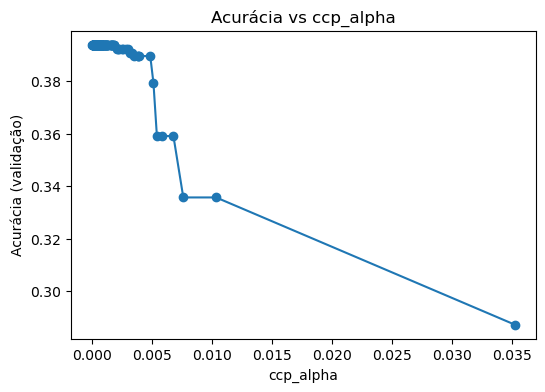

In [5]:
# Construir árvore apenas com as 3 melhores variáveis
melhores_variaveis = top3.index.tolist()

X_train_top3 = X_train_split[melhores_variaveis]
X_valid_top3 = X_valid[melhores_variaveis]

# Obter valores possíveis de ccp_alpha
path = DecisionTreeClassifier(random_state=1729).cost_complexity_pruning_path(X_train_top3, y_train_split)
ccp_alphas = path.ccp_alphas

# Armazenar resultados
resultados = []

for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(max_depth=4, ccp_alpha=alpha, random_state=1729)
    clf.fit(X_train_top3, y_train_split)
    y_pred_valid = clf.predict(X_valid_top3)
    acc = accuracy_score(y_valid, y_pred_valid)
    resultados.append((alpha, acc))

# Converter em DataFrame para análise
resultados_df = pd.DataFrame(resultados, columns=["ccp_alpha", "accuracy"])

# Encontrar o melhor alpha
melhor_alpha = resultados_df.loc[resultados_df["accuracy"].idxmax(), "ccp_alpha"]

print("\nMelhor ccp_alpha encontrado:", melhor_alpha)
print(resultados_df.sort_values(by="accuracy", ascending=False).head())

plt.figure(figsize=(6,4))
plt.plot(resultados_df["ccp_alpha"], resultados_df["accuracy"], marker='o')
plt.xlabel("ccp_alpha")
plt.ylabel("Acurácia (validação)")
plt.title("Acurácia vs ccp_alpha")
plt.show()

### 5. Avaliação do modelo

Avalie a árvore encontrada no item anterior na base de testes.


Acurácia na base de teste: 0.3699


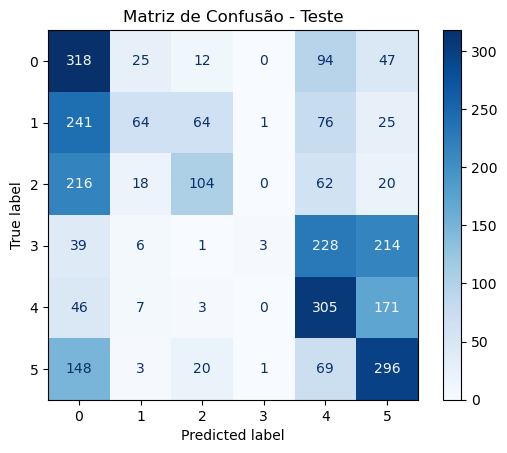

In [6]:
# Avaliar no conjunto de teste
X_test_top3 = X_test_reduzido[melhores_variaveis]
y_test = X_test_reduzido["activity"]

# Treinar árvore final
clf_final = DecisionTreeClassifier(max_depth=4, ccp_alpha=melhor_alpha, random_state=1729)
clf_final.fit(pd.concat([X_train_top3, X_valid_top3]),
              pd.concat([y_train_split, y_valid]))

# Prever e avaliar
y_pred_test = clf_final.predict(X_test_top3)
acc_test = accuracy_score(y_test, y_pred_test)

print("\nAcurácia na base de teste:", round(acc_test, 4))

# Matriz de confusão
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format=".0f")
plt.title("Matriz de Confusão - Teste")
plt.show()